In [8]:
from dataclasses import dataclass
from scipy import signal
import dataclasses
import numpy as np
from uastyle import colors
import matplotlib.pyplot as plt


@dataclass
class Data:
    data: list
    start: int = None
    end: int = None
    x_len: list = 100

    def x(self, default_start, default_end):
        if self.start is not None and self.end is not None:
            return np.linspace(self.start, self.end, self.x_len)
        return np.linspace(default_start, default_end, self.x_len)


@dataclass
class Element:
    start: float
    end: float
    color: str = None
    height: int = 1
    name: str = ""
    subname: str = ""
    x_label: str = ""
    y_label: str = ""
    y_coord: float = None
    data: Data = None
    alpha: float = 1

    def get_data(self) -> list[Data]:
        if isinstance(self.data, list):
            return self.data
        else:
            return [self.data]

    def __call__(self, **kwds):
        return dataclasses.replace(self, **kwds)


@dataclass
class Line:
    name: str
    elements: list[Element]
    color: str = None

    def __call__(self, **kwds):
        return dataclasses.replace(self, **kwds)

In [9]:
from scipy import signal


def arrow_between_elements(ax, elm1: Element, elm2: Element, text: str = ""):
    arrow_between_coordinates(
        ax,
        (elm1.end, elm1.y_coord + elm1.height / 2),
        (elm2.start, elm2.y_coord + elm2.height / 2),
        text,
    )


def arrow_between_coordinates(ax, coord1, coord2, text, ha="center", va="bottom"):
    ax.annotate(
        "",
        xy=(coord1[0], coord1[1]),
        xycoords="data",
        xytext=(coord2[0], coord2[1]),
        textcoords="data",
        arrowprops=dict(arrowstyle="<->"),
    )
    if text:
        ax.annotate(
            text,
            ((coord1[0] + coord2[0]) / 2, (coord1[1] + coord2[1]) / 2),
            ha=ha,
            va=va,
        )


def const_data(amp, start, end):
    return Data(np.array([amp] * 2), x_len=2, start=start, end=end)


def draw_lines(ax, lines, margin=0):
    time_start = 0
    time_end = 0
    for line in lines:
        for elm in line.elements:
            time_start = min(time_start, elm.start - 2)
            time_end = max(time_end, elm.end + 1)
    time_start = min(time_start, 0)
    for i, line in enumerate(lines):
        y = 1.5 * i
        color = line.color or colors[i]
        ax.annotate(line.name, (time_start, y), ha="left", va="bottom", size=14)
        ax.plot([time_start, time_end], [y] * 2, color=color)
        for elm in line.elements:
            elm.y_coord = y
            if elm.data is None:
                elm.data = Data(np.array([1, 1]), x_len=2)

            last_ended = elm.start
            data_lst = []
            for data in elm.get_data():
                elm_start = data.start or elm.start
                if last_ended != elm_start:
                    new_data = Data(
                        np.array([1, 1]), x_len=2, start=last_ended, end=elm_start
                    )
                    data_lst.append(new_data)
                data_lst.append(data)
                last_ended = data.end or elm.end

            if last_ended != elm.end:
                new_data = Data(
                    np.array([1, 1]), x_len=2, start=last_ended, end=elm.end
                )
                data_lst.append(new_data)

            for data in data_lst:
                ax.fill_between(
                    data.x(elm.start, elm.end),
                    y + elm.height * data.data / max(data.data),
                    [y] * data.x_len,
                    color=color,
                    alpha=elm.alpha,
                )

            if elm.subname:
                ax.annotate(
                    elm.subname,
                    ((elm.start + elm.end) / 2, y + elm.height),
                    ha="center",
                    va="bottom",
                )
            if elm.name:
                ax.annotate(
                    elm.name,
                    ((elm.start + elm.end) / 2, y + elm.height / 2),
                    ha="center",
                    va="center",
                )
            if elm.x_label and not elm.y_label:
                arrow_between_coordinates(
                    ax,
                    (elm.start, y + elm.height / 3),
                    (elm.end, y + elm.height / 3),
                    elm.x_label,
                )
            if elm.y_label and not elm.x_label:
                arrow_between_coordinates(
                    ax,
                    ((elm.start + elm.end) / 2, y),
                    ((elm.start + elm.end) / 2, y + elm.height),
                    elm.y_label,
                    ha="left",
                    va="center",
                )
            if elm.y_label and elm.x_label:
                arrow_between_coordinates(
                    ax,
                    (elm.start, y + elm.height / 3),
                    (elm.end, y + elm.height / 3),
                    elm.x_label,
                )
                arrow_between_coordinates(
                    ax,
                    (elm.start + 2 * (elm.end - elm.start) / 3, y),
                    (elm.start + 2 * (elm.end - elm.start) / 3, y + elm.height),
                    elm.y_label,
                    ha="left",
                    va="center",
                )
    ax.set_ylim(0 - margin, y + 1 + margin)

In [10]:
def exp_filter(start=0, end=1, points=Data.x_len, tau=None):
    tau = tau or points / 5
    x = np.linspace(0, 5 * tau, points)
    return end + (start - end) * np.exp(-x / tau)

/var/folders/nh/176gzt1s1jd887n359pc9_jr0000gn/T/ipykernel_5696/3205352423.py:15: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.window.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  start=4.5, end=5.5, name="$\pi$", data=Data(signal.gaussian(Data.x_len, std=20))


(-2.45, 7.45, 0.0, 5.5)

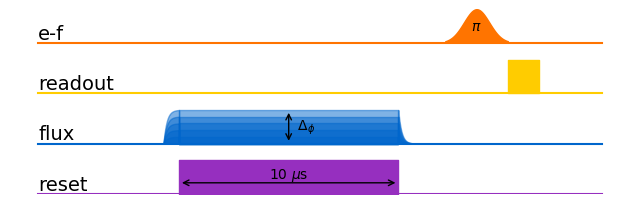

In [12]:
# Sideband cooling

flux = Element(
    start=0,
    end=4,
    y_label="  $\Delta_\phi$  ",
    alpha=0.5,
    data=[Data(exp_filter(0, 1), 0, 0.25), Data(exp_filter(1, 0), 3.75, 4)],
)

flux_list = [flux(height=h, y_label="") for h in np.arange(0.2, 0.8, 0.2)] + [flux]
flux_line = Line("flux", flux_list, color=colors[0])

pi = Element(
    start=4.5, end=5.5, name="$\pi$", data=Data(signal.gaussian(Data.x_len, std=20))
)

readout = Element(start=5.5, end=6)

reset = Element(start=0.25, end=3.75, x_label="10 $\mu$s")

reset_line = Line("reset", [reset], color=colors[3])
ef_line = Line("e-f", [pi], color=colors[2])
readout_line = Line("readout", [readout], color=colors[1])
lines = [reset_line, flux_line, readout_line, ef_line]


fig, ax = plt.subplots(1, 1, figsize=(8, len(lines) * 0.6))
draw_lines(ax, lines)
ax.axis("off")
# fig.savefig(export_path / "sideband_cooling_pulses.svg")

In [ ]:
signal.gaussian

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pulsefig
from pulsefig.element import Element
from pulsefig.line import Line, LineEnsemble
import numpy as np

LineEnsemble with 2 lines :
	Line : e_f
	Line : g_h

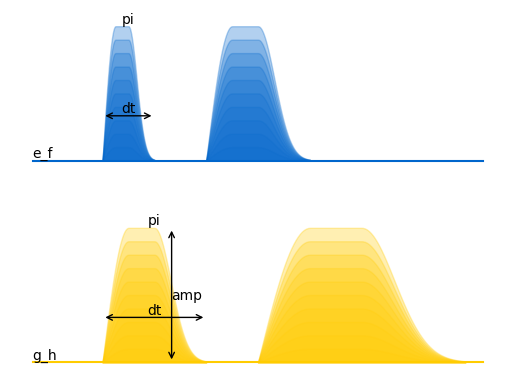

In [2]:
fig, ax = plt.subplots(1, 1)
ax.axis("off")

line1 = Line("e_f").attach_elements(
    Element(0, 1)
    .set(alpha=0.3, marker="0")
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
    .set(subtitle="pi", xlabel="dt"),
    Element(2, 4)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)
line2 = Line("g_h").attach_elements(
    Element(0, 2)
    .set(alpha=0.3, marker="0", subtitle="pi", xlabel="dt", ylabel="amp")
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
    Element(duration=4, delay=1)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)
# line2 = Line("g_h").attach_elements(
#     Element(0, 1)
#     .update_style(color="red", alpha=0.3, data_index=0)
#     .sweep_height(start_color="tab:red", start_alpha=0.1),
#     Element(2, 4)
#     .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
#     .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
#     .update_style(color="blue", alpha=0.3, data_index=0)
#     .sweep_height(start_color="tab:blue", start_alpha=0.1),
# )
ens = line1 + line2  # .draw(ax)
# ens = (line2.copy() + ens).draw(ax)
ens.draw(ax)

set aspect to 0.6666666666666666


0.4583120797097057

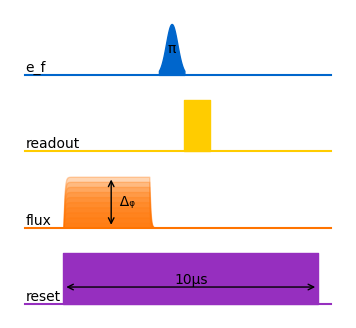

In [16]:
reset_line = Line("reset").attach_elements(Element(0, 10).set(xlabel="10μs"))
flux_line = Line("flux").attach_elements(
    flux_rise := Element.ExpFilter(0, 3.75, duration=0.2)
    .set(ylabel="  Δᵩ")
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
)

ef_line = Line("e_f").attach_elements(
    ef_pi := Element.Gaussian(flux_rise, duration=1).set(title="π")
)
readout_line = Line("readout").attach_elements(Element(ef_pi, duration=1, delay=0.5))
ens = ef_line + readout_line + flux_line + reset_line

figsize = (1 * 6, 4)  # (2 * 8, len(ens.lines) * 0.8)
fig, ax1 = plt.subplots(1, 1, figsize=figsize)

ens.config_ax(ax1).draw(ax1)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
xs = xlim[1] - xlim[0]
ys = ylim[1] - ylim[0]


ax1.set_aspect(2)
ys / xs

In [18]:
0.75 * 0.61

0.4575

In [20]:
 * x =  0.75/(ys / xs)

0.3437340597822793

In [5]:
[line.y_index for line in ens.lines]

[0, 1, 2]